<a href="https://colab.research.google.com/github/mrdso2-iscte/IAA_PROJECT/blob/main/IAA_92424_92991.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
!pip install kmodes
from kmodes.kmodes import KModes
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN
from sklearn import metrics
import io
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from numpy.random import seed
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import f1_score as sk_f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.neural_network import MLPClassifier


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Ponto 1**

In [44]:
d0=pd.read_csv('2010.csv',sep = ';', encoding="ISO-8859-1")
d1=pd.read_csv('2011.csv',sep = ';', encoding="ISO-8859-1")
d2=pd.read_csv('2012.csv',sep = ';', encoding="ISO-8859-1")
d3=pd.read_csv('2013.csv',sep = ';', encoding="ISO-8859-1")
d4=pd.read_csv('2014.csv',sep = ';', encoding="ISO-8859-1")
d5=pd.read_csv('2015.csv',sep = ';', encoding="ISO-8859-1")
d6=pd.read_csv('2016.csv',sep = ';', encoding="ISO-8859-1")
d7=pd.read_csv('2017.csv',sep = ';', encoding="ISO-8859-1")
d8=pd.read_csv('2018.csv',sep = ';', encoding="ISO-8859-1")
d9=pd.read_csv('2019.csv',sep = ';', encoding="ISO-8859-1")
data=pd.concat([d0, d1,d2,d3,d4,d5,d6,d7,d8,d9], sort=False)

In [45]:
data.size

14077512

In [46]:
month_percentages=[]

In [47]:
def monthly_graph_plot(data):
  month_groupby=data.groupby(data['Datahora'].str.split(':').str[1])
  data_frame = pd.DataFrame({'Mes':month_groupby.groups.keys(), 'N acidentens':month_groupby.size()})
  ax = data_frame.plot.bar(x='Mes', y='N acidentens', rot=0,figsize=(10, 7),color='orange')

  for p in ax.patches:
      width = p.get_width()
      height = p.get_height()
      x, y = p.get_xy()
      month_percentages.append(height/len(data)) 
      ax.annotate(f'{round(height/len(data)*100,1)}%', (x + width/2, y + height*1.02), ha='center')
  return  month_groupby

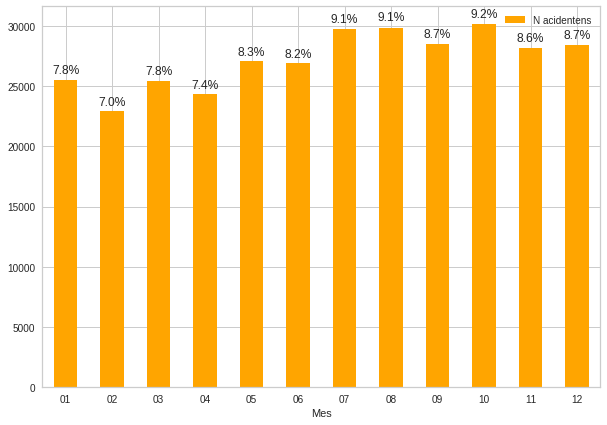

In [48]:
month_groupby=monthly_graph_plot(data)

In [49]:
data= pd.DataFrame(columns = data.columns)
month_samples=[]

for month_number, month_data in month_groupby:
  month_data_sample=month_data.sample(int(round(10000*month_percentages[int(month_number)-1]))) 
  data.append(month_data_sample, ignore_index = True)
  month_samples.append(month_data_sample)

# resize the data 

for i in range(12):
 data=pd.concat([data,month_samples[i]], ignore_index = True)

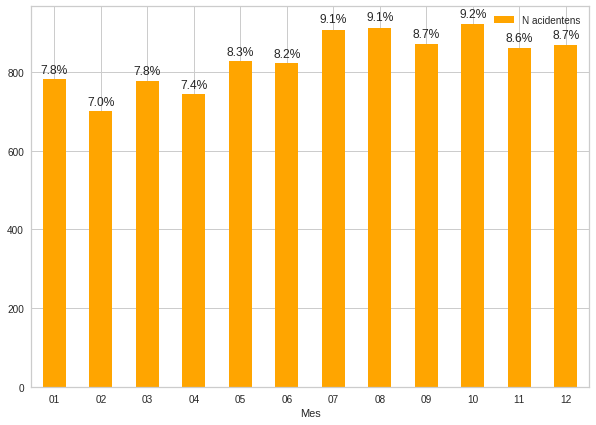

In [50]:
monthly_graph_plot(data)

1 Extract a random sample of 10000+ examples taking random examples from all files from 2010 to 2019. Save the sample;

In [51]:
# Save the sample to a csv file
data.to_csv('accidents.csv', index = False)

In [52]:
data.size

430000

In [53]:
accidents_df=pd.read_csv('accidents.csv',sep = ',')

In [54]:
accidents_df.size

430000

# Ponto 2

2. Decide which (if any) characteristics should be normalized, discretized, or change format in any way. Perform these transformations in the sample and save the new file under a different name;

## Categorização da coluna 'Periodos do Dia'

In [55]:
accidents_df['Periodo do Dia']=accidents_df['Datahora'].str.split(' ').str[-1]     

## METER A COLUNA DATAHORA PARA DATETIME
accidents_df['Periodo do Dia'] = pd.to_datetime(accidents_df['Periodo do Dia'])
     

slots=['06:00:00','12:00:00','18:00:00']
hours=pd.to_datetime(slots)
day_slots=[]
for index in accidents_df.index:  
  if accidents_df['Periodo do Dia'][index] < hours[0]:
    day_slots.append('Madrugada')
  elif (accidents_df['Periodo do Dia'][index] >= hours[0]) & (accidents_df['Periodo do Dia'][index] < hours[1]):
    day_slots.append('Manha')
  elif  (accidents_df['Periodo do Dia'][index] >= hours[1]) & (accidents_df['Periodo do Dia'][index] < hours[2]):
    day_slots.append('Tarde')
  else:
    day_slots.append('Noite')

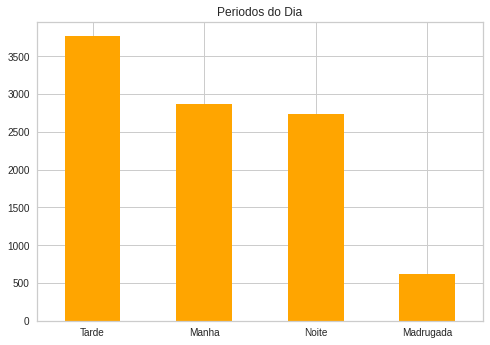

In [56]:
accidents_df['Periodo do Dia']=day_slots
accidents_df['Periodo do Dia'].value_counts().plot(kind = 'bar',rot = 0,color='orange',title="Periodos do Dia")

## Categorização da coluna 'Tipo de acidentes'

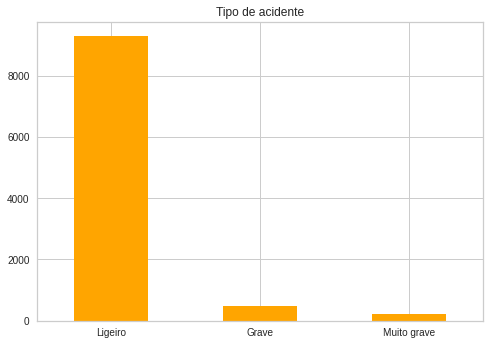

In [57]:
accident_type=[]
for index in accidents_df.index: 
  if (accidents_df['Num. Mortos a 30 dias'][index]>0):    
    accident_type.append('Muito grave')
  elif (accidents_df['Num. Feridos graves a 30 dias'][index]>0) & (accidents_df['Num. Mortos a 30 dias'][index]==0):
    accident_type.append('Grave')
  else:
     accident_type.append('Ligeiro')
accidents_df['Tipo de Acidente']=accident_type
accidents_df['Tipo de Acidente'].value_counts().plot(kind = 'bar',rot = 0,color='orange',title="Tipo de acidente")

## Categorização da coluna 'Concelho'

In [58]:
# Replace the names in the accidents dataframe that were different in the 'nuts_site_csv'
accidents_df=accidents_df.replace('Sobral Monte Agraco','Sobral de Monte Agraco')
accidents_df=accidents_df.replace('Lagoa (Algarve)','Lagoa')
accidents_df=accidents_df.replace('Freixo Espada a Cinta','Freixo de Espada a Cinta')

In [59]:
# Reads from the 'nuts_site_csv', keeping the column 'Concelho' and removing the elements that we will not be using
nuts_site_df=pd.read_csv('nuts_site.csv',sep = ';', encoding="ISO-8859-1")
nuts_site_df= nuts_site_df[['NUTS II','CONCELHO']]
drop_elements= nuts_site_df[(nuts_site_df['NUTS II']=='REGIÃO AUTÓNOMA DOS AÇORES') | (nuts_site_df['NUTS II']=='REGIÃO AUTÓNOMA DA MADEIRA')].index
nuts_site_df.drop(drop_elements, inplace=True)
nuts_site_df = nuts_site_df.drop_duplicates(keep='first')
cols = nuts_site_df.select_dtypes(include=[object]).columns
nuts_site_df[cols] = nuts_site_df[cols].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))
nuts_site_df

,NUTS II,CONCELHO
0,CENTRO,Agueda
11,CENTRO,Albergaria-a-Velha
17,CENTRO,Anadia
27,NORTE,Arouca
43,CENTRO,Aveiro
...,...,...
2816,NORTE,Tarouca
2823,CENTRO,Tondela
2842,CENTRO,Vila Nova de Paiva
2847,CENTRO,Viseu


In [60]:
for index in accidents_df.index:
  concelho = accidents_df['Concelho'][index]
  zona=nuts_site_df[(nuts_site_df['CONCELHO']==concelho)].values
  accidents_df['Concelho'][index]=zona[0][0]

accidents_df=accidents_df.rename(columns={"Concelho": "Zona"})

<ipython-input-60-72a8aa3dfbc5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accidents_df['Concelho'][index]=zona[0][0]


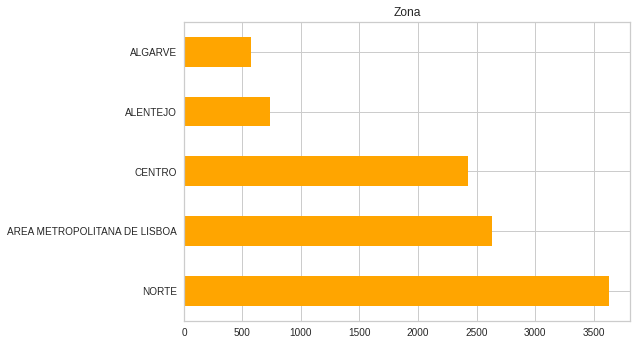

In [61]:
accidents_df['Zona'].value_counts().plot(kind = 'barh',rot = 0,color='orange',title="Zona")

## Imputação de dados para a coluna 'Velocidade local'

In [62]:
velocidades = np.unique(accidents_df['Velocidade local'])
velocidade_local_not_null = accidents_df[accidents_df['Velocidade local'].notnull()]
velocidade_local_null = accidents_df[accidents_df['Velocidade local'].isnull()]
velocidade_geral_null = accidents_df[accidents_df['Velocidade geral'].isnull()]

for ind in velocidade_local_null.index:
    if pd.isnull(accidents_df['Velocidade geral'][ind]):
        tipo_via = accidents_df['Tipos Vias'][ind]
        velocidade = [accidents_df['Velocidade local'][index] for index in velocidade_local_not_null.index if accidents_df['Tipos Vias'][index] == tipo_via]
        mean_velocidade = np.mean(velocidade)
        closest = min(velocidades, key=lambda x: abs(x - mean_velocidade))
        accidents_df['Velocidade local'][ind] = closest
    else:
        accidents_df['Velocidade local'][ind] = accidents_df['Velocidade geral'][ind]

<ipython-input-62-fea977c7f372>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accidents_df['Velocidade local'][ind] = accidents_df['Velocidade geral'][ind]
<ipython-input-62-fea977c7f372>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accidents_df['Velocidade local'][ind] = closest


## Refatorização da coluna Datahora

In [63]:
from datetime import datetime
accidents_df['Data']=accidents_df['Datahora'].str.split(' ').str[0]
accidents_df['Data']=  pd.to_datetime(accidents_df['Data'], format='%Y:%m:%d')


## Criação da coluna 'Ano'

In [64]:
accidents_df['Ano'] = accidents_df['Data'].dt.year

## Refatorização da coluna 'Natureza' (do acidente)

In [65]:
natureza_type=[]
for index in accidents_df.index: 
  if ("Despiste" in accidents_df['Natureza'][index]):
    natureza_type.append('Despiste')
  elif ("Colisão" in accidents_df['Natureza'][index]):
   natureza_type.append('Colisao')
  else:
    natureza_type.append('Atropelamento')
accidents_df['Natureza'] = natureza_type

In [66]:
accidents_df.columns


Index(['Id. Acidente', 'Datahora', 'Dia', 'Mês', 'Hora',
       'Entidades Fiscalizadoras', 'Velocidade local', 'Velocidade geral',
       'Dia da Semana', 'Latitude GPS', 'Longitude GPS',
       'Num. Mortos a 30 dias', 'Num. Feridos graves a 30 dias',
       'Num. Feridos ligeiros a 30 dias', 'Características Tecnicas1',
       'Cond Aderência', 'Distrito', 'Zona', 'Freguesia', 'Pov. Proxima',
       'Nome arruamento', 'Tipos Vias', 'Cod Via', 'Estado Conservação', 'Km',
       'Factores Atmosféricos', 'Reg Circulação1', 'Intersecção Vias',
       'Localizações', 'Luminosidade', 'Marca Via', 'Natureza', 'Obras Arte',
       'Obstáculos', 'Sentidos', 'Sinais', 'Sinais Luminosos', 'Tipo Piso',
       'Traçado 1', 'Traçado 2', 'Traçado 3', 'Traçado 4', 'Via Trânsito',
       'Periodo do Dia', 'Tipo de Acidente', 'Data', 'Ano'],
      dtype='object')

# Ponto 3

## Visualizações sasonais 

Verify which characteristics are seasonal (have different average values in different times of the year). Provide graphical views of these seasonal differences;

### Visualização por estações do ano

In [67]:
estacoes_df = pd.to_datetime(accidents_df['Data'], format='%Y:%m:%d')

s_spring=pd.to_datetime('20:03',format='%d:%m')
s_summer=pd.to_datetime('21:06',format='%d:%m')
s_autumn=pd.to_datetime('23:09',format='%d:%m')
s_winter=pd.to_datetime('21:12',format='%d:%m')

estacoes=[]
for index in estacoes_df.index:  
  if estacoes_df[index].month > s_spring.month and estacoes_df[index].month < s_summer.month:
    estacoes.append('Primavera')
  elif estacoes_df[index].month == s_spring.month and estacoes_df[index].month == s_summer.month:
    if estacoes_df[index].day >= s_spring.day and estacoes_df[index].day < s_summer.day:
      estacoes.append('Primavera')    
  elif estacoes_df[index].month > s_summer.month and estacoes_df[index].month < s_autumn.month:
    estacoes.append('Verao')
  elif estacoes_df[index].month == s_summer.month and estacoes_df[index].month == s_autumn.month:
    if estacoes_df[index].day >= s_summer.day and estacoes_df[index].day < s_autumn.day:
      estacoes.append('Verao')
  elif estacoes_df[index].month > s_autumn.month and estacoes_df[index].month < s_winter.month:
    estacoes.append('Outono')
  elif estacoes_df[index].month == s_autumn.month and estacoes_df[index].month == s_winter.month:
    if estacoes_df[index].day >= s_autumn.day and estacoes_df[index].day < s_winter.day:
      estacoes.append('Outono')
  else:
     estacoes.append('Inverno')

accidents_df['Estacao do Ano']=estacoes

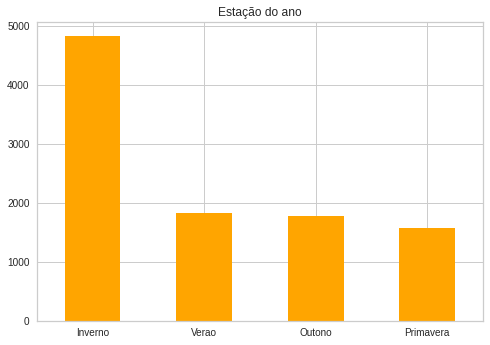

In [68]:
accidents_df['Estacao do Ano'].value_counts().plot(kind = 'bar',rot = 0,color='orange',title="Estação do ano")


### Visualização por Periodo do Dia

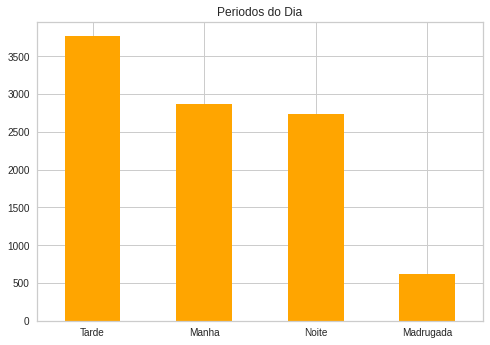

In [69]:
#Periodo do dia

accidents_df['Periodo do Dia'].value_counts().plot(kind = 'bar',rot = 0,color='orange',title="Periodos do Dia")

### Visualização por Dia da Semana

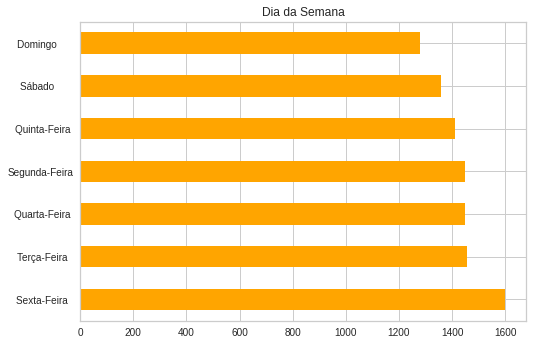

In [70]:
#dias da semana
accidents_df['Dia da Semana'].value_counts().plot(kind = 'barh',rot = 0,color='orange',title="Dia da Semana")

### Visualização por Ano 

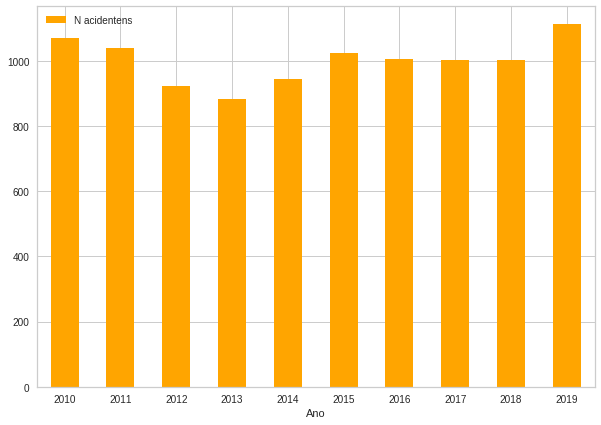

In [71]:

ano_groupby=accidents_df.groupby(accidents_df['Data'].dt.strftime('%Y'))
df = pd.DataFrame({'Ano':ano_groupby.groups.keys(), 'N acidentens':ano_groupby.size()})
ax = df.plot.bar(x='Ano', y='N acidentens', rot=0,figsize=(10, 7),color='orange')

## Vizualizações de cada caracteristica pela distibuição de cada estaçao do ano

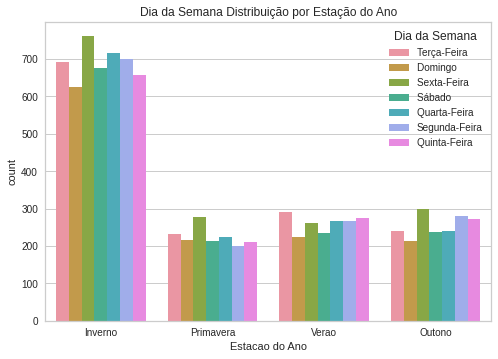

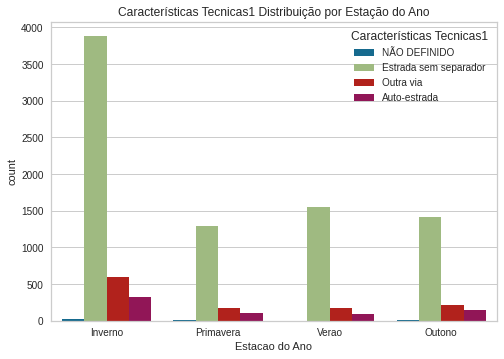

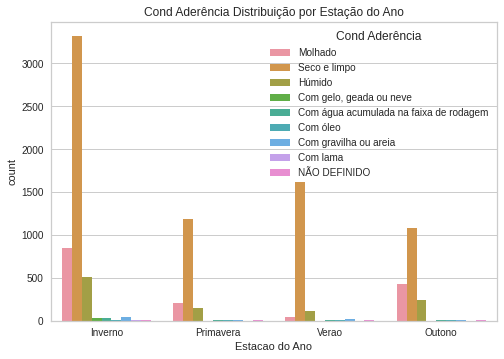

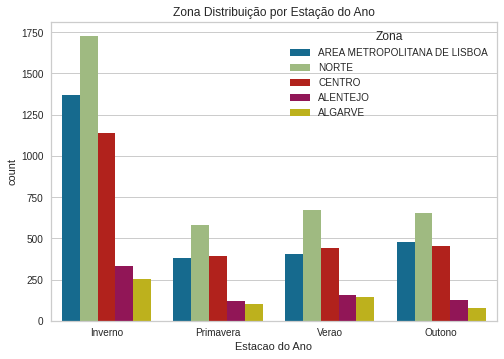

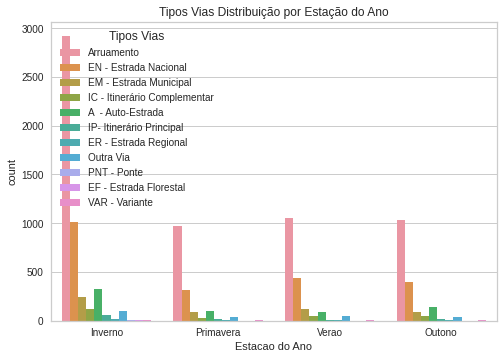

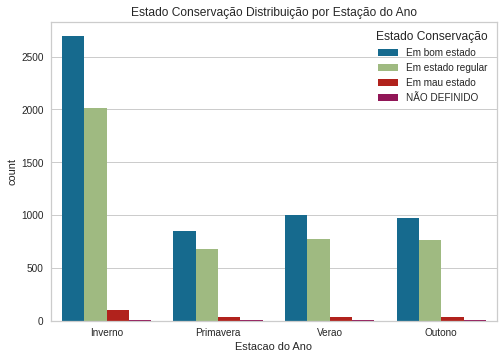

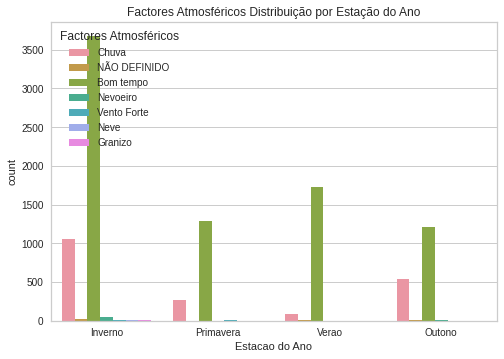

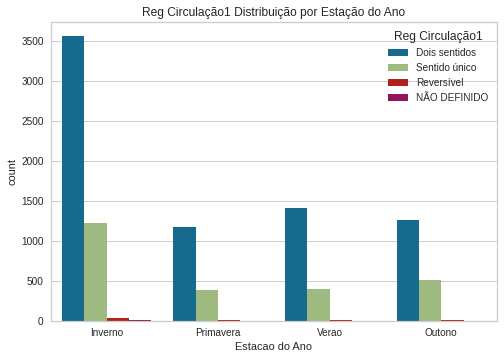

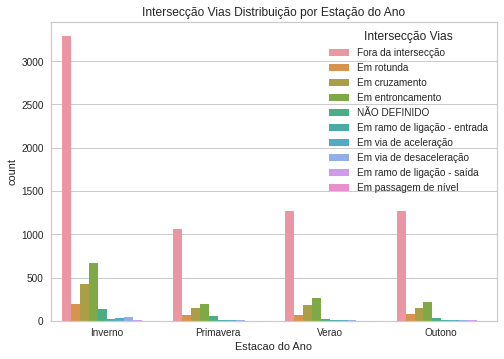

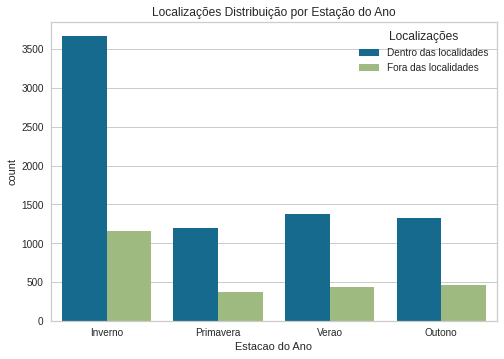

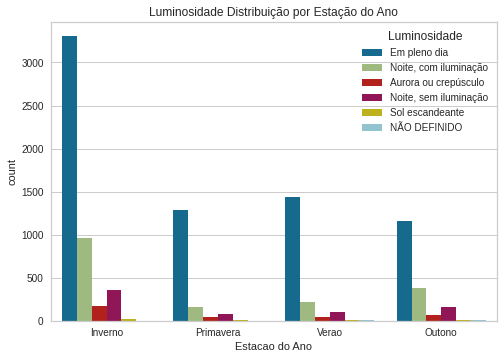

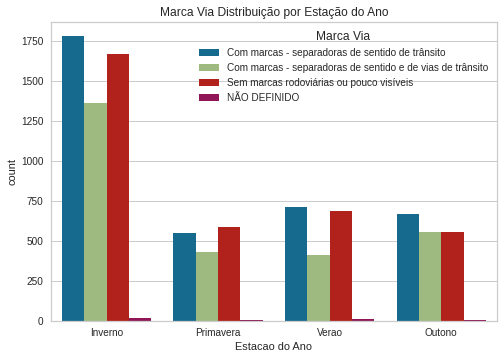

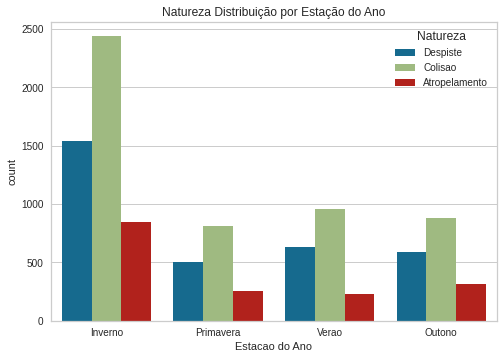

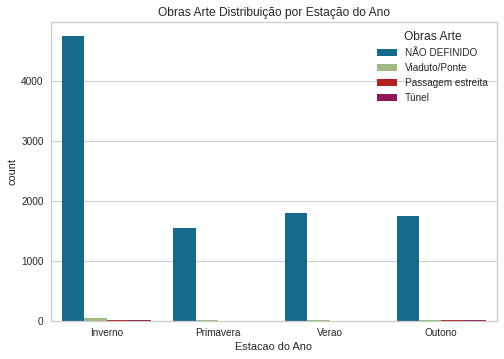

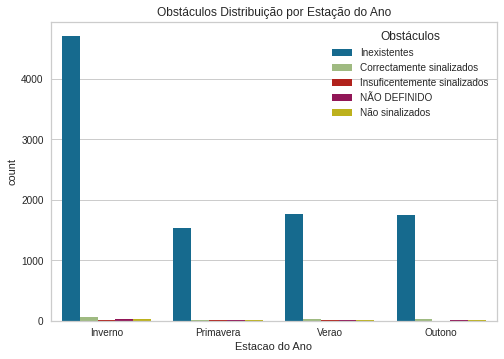

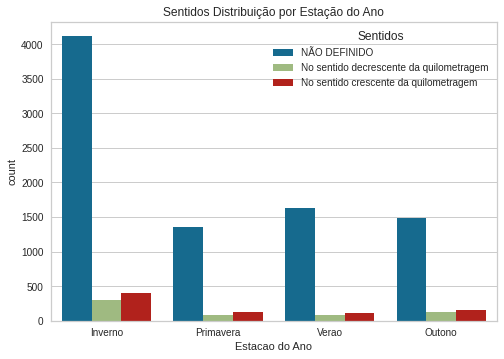

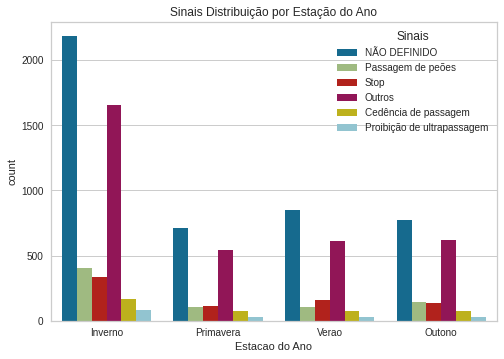

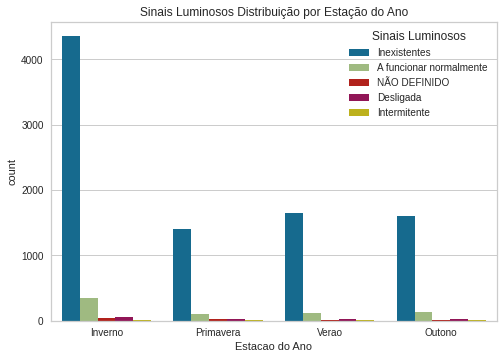

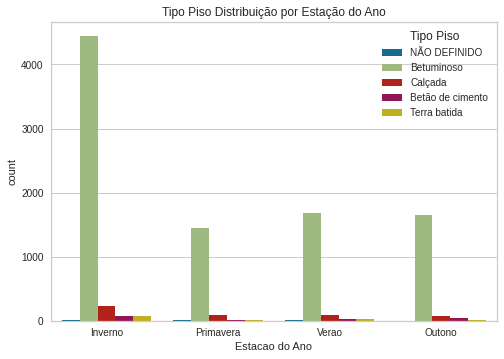

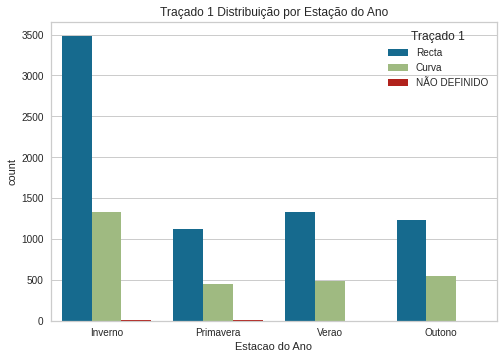

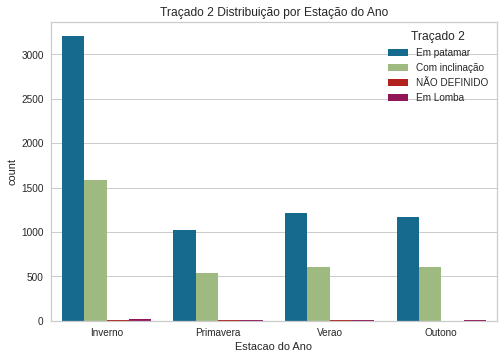

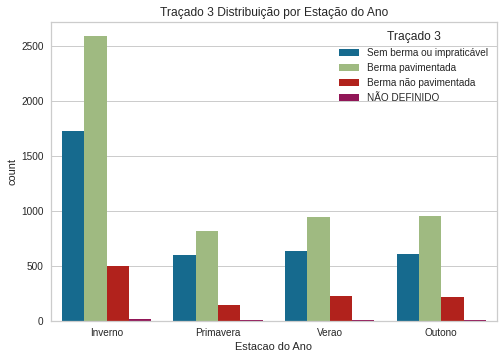

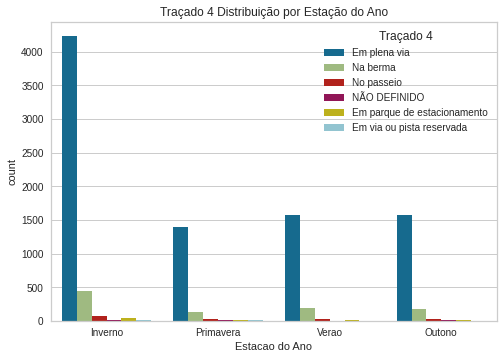

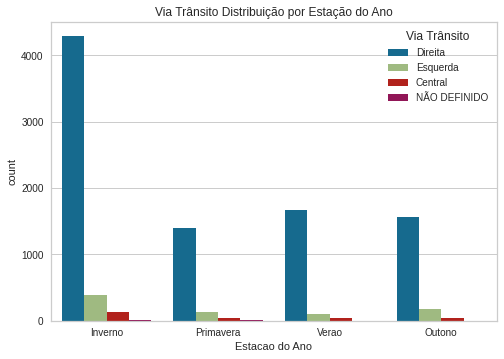

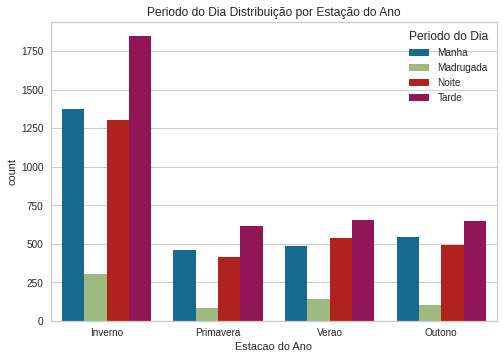

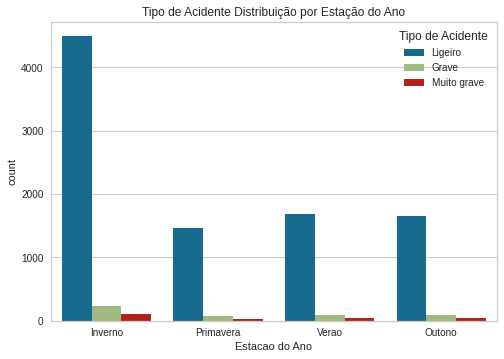

In [79]:
import seaborn as sns


columns = ['Dia da Semana', 'Características Tecnicas1',
       'Cond Aderência', 'Zona', 'Tipos Vias', 'Estado Conservação', 'Factores Atmosféricos', 'Reg Circulação1', 'Intersecção Vias',
       'Localizações', 'Luminosidade', 'Marca Via', 'Natureza', 'Obras Arte',
       'Obstáculos', 'Sentidos', 'Sinais', 'Sinais Luminosos', 'Tipo Piso',
       'Traçado 1', 'Traçado 2', 'Traçado 3', 'Traçado 4', 'Via Trânsito',
       'Periodo do Dia', 'Tipo de Acidente']

for column in columns:
    plt.figure()
    sns.countplot(x='Estacao do Ano', hue=column, data=accidents_df)
    plt.title(f'{column} Distribuição por Estação do Ano')
    plt.show()

## Mais  Visualizações

### Vizualização 'Características Tecnicas1', 'Tipos Vias'

In [ ]:
groupby = accidents_df.groupby([ 'Características Tecnicas1','Tipos Vias']).size()
print(groupby)

Características Tecnicas1  Tipos Vias                  
Auto-estrada               A  - Auto-Estrada                629
Estrada sem separador      Arruamento                      5277
                           EF - Estrada Florestal            12
                           EM - Estrada Municipal           533
                           EN - Estrada Nacional           1921
                           ER - Estrada Regional             41
                           IC - Itinerário Complementar     111
                           IP- Itinerário Principal          26
                           Outra Via                        176
                           PNT - Ponte                        1
                           VAR - Variante                    22
NÃO DEFINIDO               Arruamento                        32
                           EM - Estrada Municipal             3
                           EN - Estrada Nacional             13
                           Outra Via            

# Ponto 4

Verify which characteristics are unbalanced (have much more elements of one class than the others). Present graphical views of the distributions of some unbalanced characteristics you deem relevant for the problem;

In [ ]:
accidents_df.columns

Index(['Id. Acidente', 'Datahora', 'Dia', 'Mês', 'Hora',
       'Entidades Fiscalizadoras', 'Velocidade local', 'Velocidade geral',
       'Dia da Semana', 'Latitude GPS', 'Longitude GPS',
       'Num. Mortos a 30 dias', 'Num. Feridos graves a 30 dias',
       'Num. Feridos ligeiros a 30 dias', 'Características Tecnicas1',
       'Cond Aderência', 'Distrito', 'Zona', 'Freguesia', 'Pov. Proxima',
       'Nome arruamento', 'Tipos Vias', 'Cod Via', 'Estado Conservação', 'Km',
       'Factores Atmosféricos', 'Reg Circulação1', 'Intersecção Vias',
       'Localizações', 'Luminosidade', 'Marca Via', 'Natureza', 'Obras Arte',
       'Obstáculos', 'Sentidos', 'Sinais', 'Sinais Luminosos', 'Tipo Piso',
       'Traçado 1', 'Traçado 2', 'Traçado 3', 'Traçado 4', 'Via Trânsito',
       'Periodo do Dia', 'Tipo de Acidente', 'Data', 'Ano', 'Estacao do Ano'],
      dtype='object')

In [ ]:
# atributos_praficar = ['Entidades Fiscalizadoras', 'Velocidade local',
#        'Dia da Semana', 'Características Tecnicas1',
#        'Cond Aderência', 'Zona',  'Tipos Vias',  'Estado Conservação',
#        'Factores Atmosféricos', 'Reg Circulação1', 'Intersecção Vias',
#        'Localizações', 'Luminosidade', 'Marca Via', 'Natureza', 'Obras Arte',
#        'Obstáculos', 'Sentidos', 'Sinais', 'Sinais Luminosos', 'Tipo Piso',
#        'Traçado 1', 'Traçado 2', 'Traçado 3', 'Traçado 4', 'Via Trânsito',
#        'Periodo do Dia', 'Tipo de Acidente',  'Estacao do Ano']



attributes_to_drop = ['Id. Acidente', 'Entidades Fiscalizadoras', 'Datahora', 'Dia', 
                      'Mês', 'Hora','Velocidade geral', 'Latitude GPS', 'Longitude GPS',
                      'Cod Via','Num. Mortos a 30 dias', 'Num. Feridos graves a 30 dias',
                      'Num. Feridos ligeiros a 30 dias',  'Distrito',  'Freguesia', 
                      'Pov. Proxima','Nome arruamento',  'Km','Data']

# acidentes_categoricos = accidents_df[accidents_df.columns.difference(attributes_to_drop)]
accidents_df = accidents_df.drop(columns = attributes_to_drop)



In [ ]:
accidents_df.columns.size

29

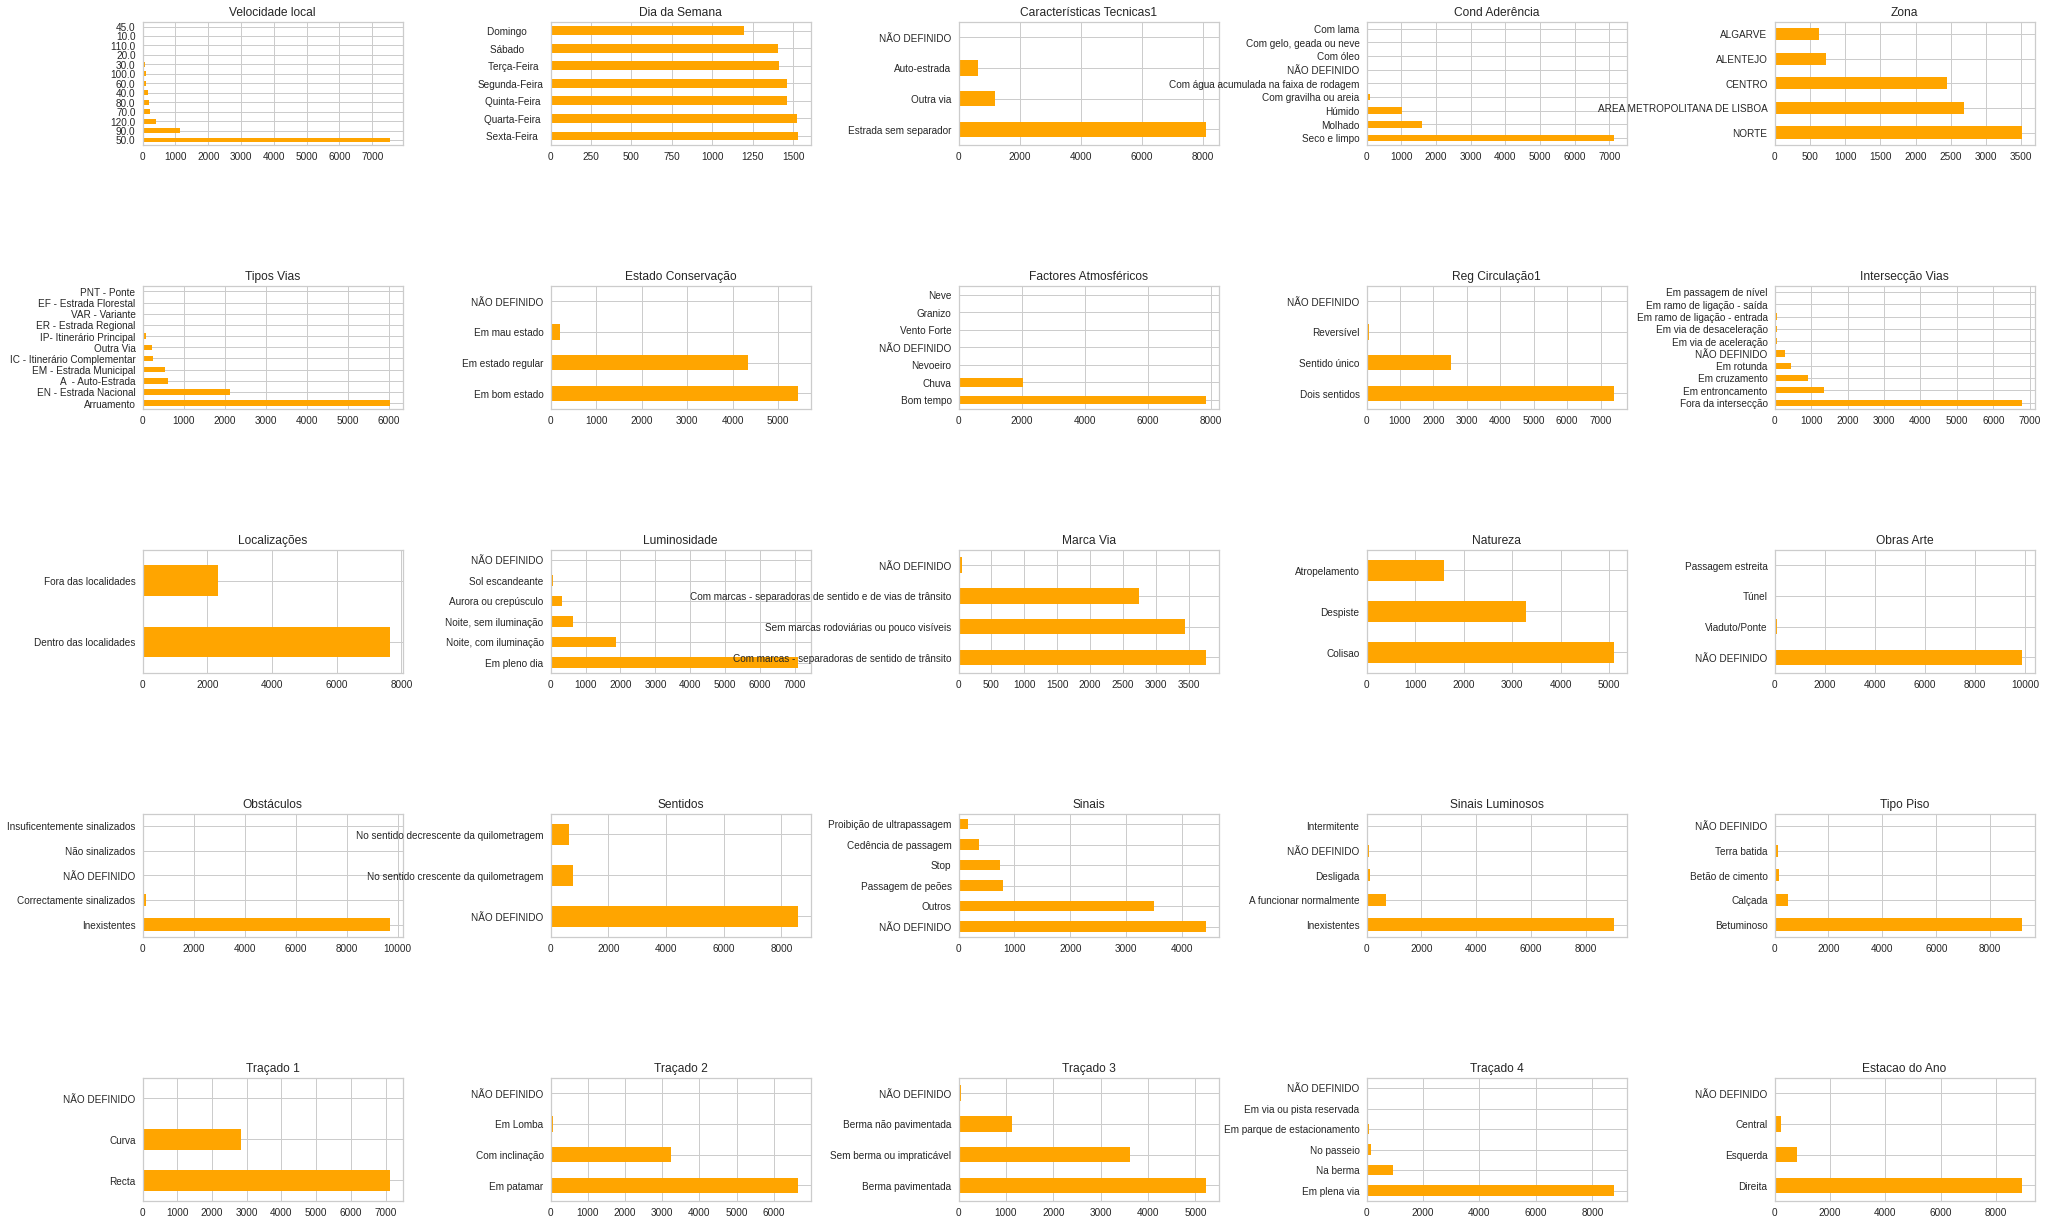

In [ ]:
fig, axes = plt.subplots(nrows = 5,ncols = 5,figsize = (30,20))
fig.tight_layout(pad=10.0)
for i, item in enumerate(accidents_df.columns):
    if i < 5:
        ax = accidents_df[item].value_counts().plot(kind = 'barh',ax=axes[0,i],rot = 0,color='orange')
        
    elif i >=5 and i < 10:
        ax = accidents_df[item].value_counts().plot(kind = 'barh',ax=axes[1,i-5],rot = 0, color='orange')
        
    elif i >=10 and i < 15:
        ax = accidents_df[item].value_counts().plot(kind = 'barh',ax=axes[2,i-10],rot = 0, color='orange')
    elif i >=15 and i < 20:
        
        ax = accidents_df[item].value_counts().plot(kind = 'barh',ax=axes[3,i-15],rot = 0, color='orange')
    elif i >=20 and i < 25:
        ax = accidents_df[item].value_counts().plot(kind = 'barh',ax=axes[4,i-20],rot = 0, color='orange')
   
    ax.set_title(item)

 

In [ ]:
#dar mais drops destas colunas Obstaculos, tipo piso, Sinais Luminosos, Traçado 4 + attributes_to_drop
attributes_to_drop= ['Obstáculos','Tipo Piso','Traçado 4','Sinais Luminosos', 'Obras Arte']

accidents_df=accidents_df.drop(columns = attributes_to_drop)

In [ ]:
print(accidents_df.columns)

Index(['Velocidade local', 'Dia da Semana', 'Características Tecnicas1',
       'Cond Aderência', 'Zona', 'Tipos Vias', 'Estado Conservação',
       'Factores Atmosféricos', 'Reg Circulação1', 'Intersecção Vias',
       'Localizações', 'Luminosidade', 'Marca Via', 'Natureza', 'Sentidos',
       'Sinais', 'Traçado 1', 'Traçado 2', 'Traçado 3', 'Via Trânsito',
       'Periodo do Dia', 'Tipo de Acidente', 'Ano', 'Estacao do Ano'],
      dtype='object')


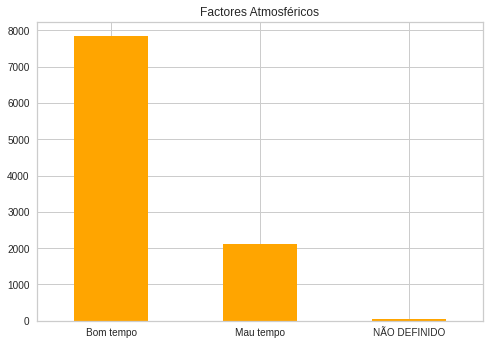

In [ ]:
accidents_df['Factores Atmosféricos'] = np.where((accidents_df['Factores Atmosféricos'] != 'Bom tempo') & (accidents_df['Factores Atmosféricos'] != 'NÃO DEFINIDO'), "Mau tempo", accidents_df['Factores Atmosféricos'])
accidents_df['Factores Atmosféricos'].value_counts().plot(kind = 'bar',rot = 0,color='orange',title='Factores Atmosféricos')

# Ponto 5

Calculate correlations between variables and explain any high correlations found; 

https://www.statology.org/correlation-between-categorical-variables/
Categoricas: https://www.statstest.com/cramers-v-2/

Cramer’s V

The analysis will result in a Cramer’s V value and a p-value. Cramer’s V ranges from 0 to 1, where 0 indicates no relationship and 1 indicates perfect association

The p-value represents the chance of seeing our results if there was no actual relationship between our variables. A p-value less than or equal to 0.05 means that our result is statistically significant and we can trust that the difference is not due to chance alone.

In [ ]:
accidents_df.columns

Index(['Velocidade local', 'Dia da Semana', 'Características Tecnicas1',
       'Cond Aderência', 'Zona', 'Tipos Vias', 'Estado Conservação',
       'Factores Atmosféricos', 'Reg Circulação1', 'Intersecção Vias',
       'Localizações', 'Luminosidade', 'Marca Via', 'Natureza', 'Sentidos',
       'Sinais', 'Traçado 1', 'Traçado 2', 'Traçado 3', 'Via Trânsito',
       'Periodo do Dia', 'Tipo de Acidente', 'Ano', 'Estacao do Ano'],
      dtype='object')

<ipython-input-218-7d4c436909ff>:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(dd, dtype=np.bool)


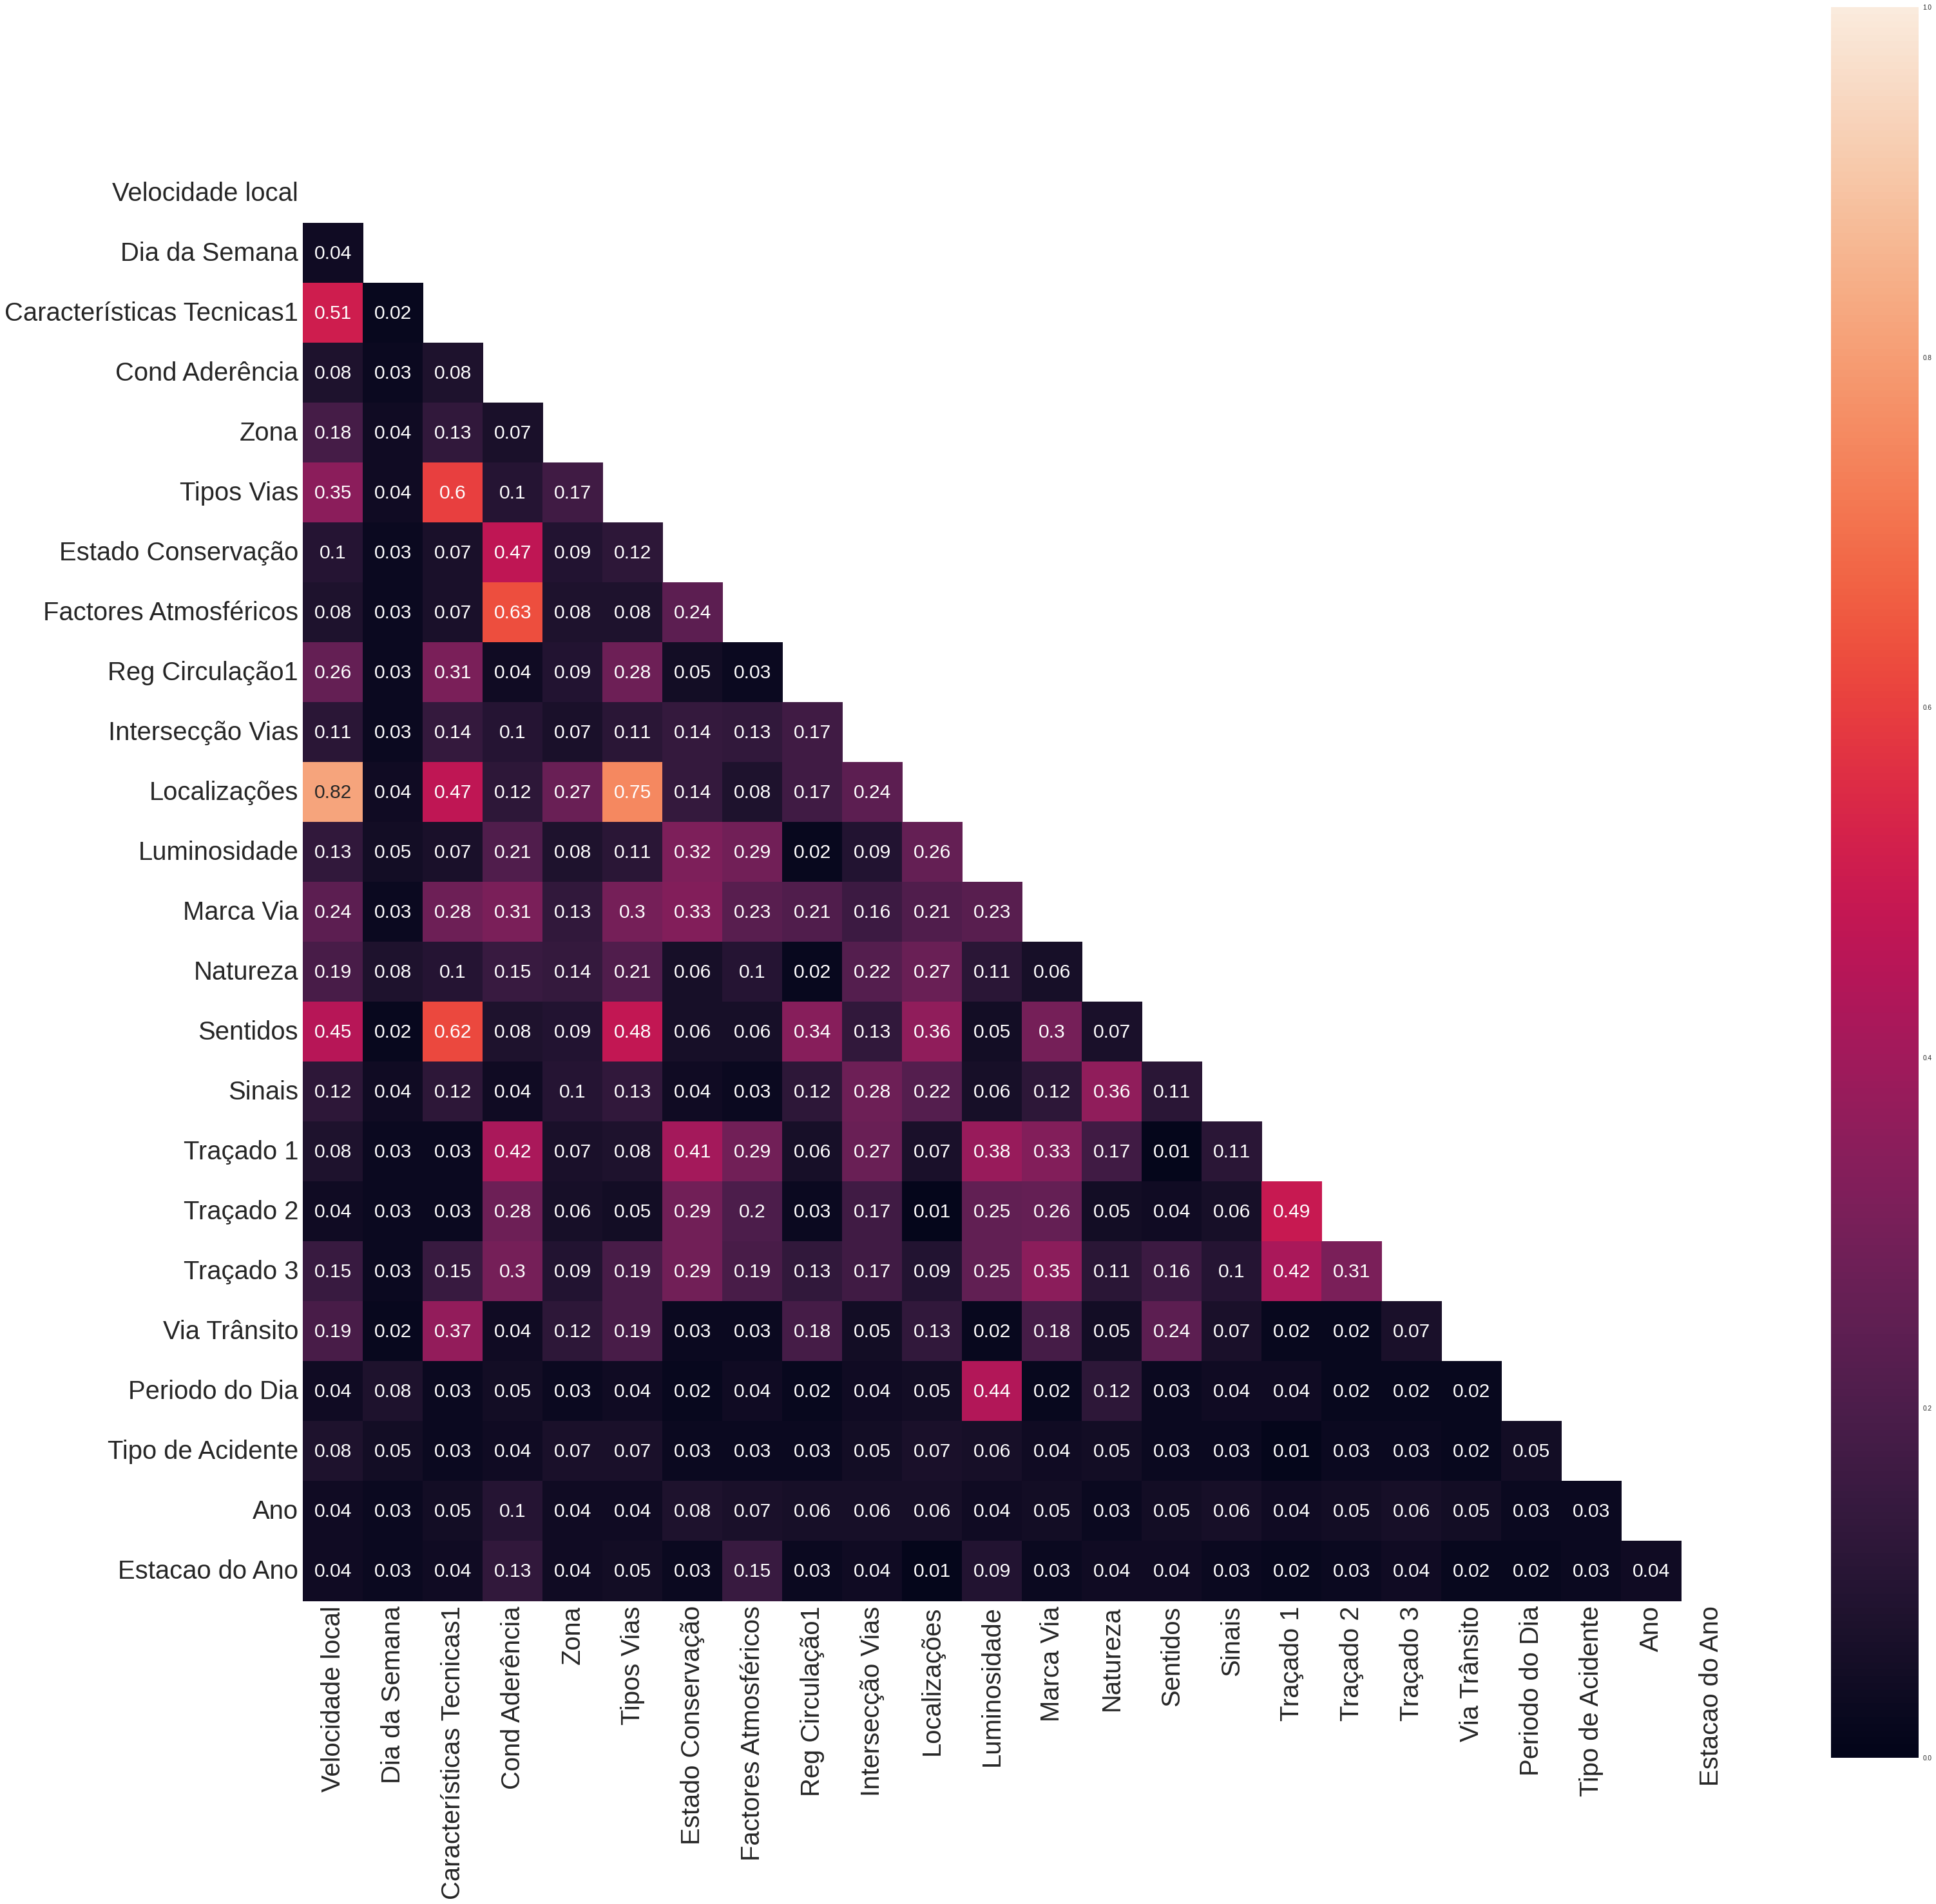

In [ ]:
#calculo das correlações
def cramer_correl(feature1, feature2,dataset):
  l = dataset.groupby([feature1, feature2]).size().unstack(fill_value=0)
  data = l.values
  X2 = stats.chi2_contingency(data, correction=False)[0]
  n = np.sum(data)
  minDim = min(data.shape)-1
  V = np.sqrt((X2/n) / minDim)
  return V

# cria a matriz
def cramer_matrix(columns_x,columns_y,dataset):
  matrix=[]
  for  x in range(len(columns_x)):
    line = []
    for  y in range(len(columns_y)):      
      line.append(round(cramer_correl(columns_x[x], columns_y[y],dataset),2))
    matrix.append(line)
  return matrix 


m = cramer_matrix(accidents_df.columns,accidents_df.columns,accidents_df)
dd = pd.DataFrame(m, index = accidents_df.columns, columns = accidents_df.columns)


mask = np.zeros_like(dd, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# mostra os mapas das correlções
with sns.axes_style("white"):
  fig, ax = plt.subplots(figsize=(50,50)) 
  hm = sns.heatmap(dd, mask=mask,vmin=0., vmax=1, square=True,annot=True,ax=ax,annot_kws={'size': 30})
  hm.set_xticklabels(hm.get_xmajorticklabels (), fontsize = 40)
  hm.set_yticklabels(hm.get_ymajorticklabels (), fontsize = 40,rotation=360)

plt.show()

correlacoes: 
melhores: 
velocidade local com caracteristicas tecnincas 1; localizacoes; sentidos;
carActs tecnicas1 com sentidos; localizacoes; tipos vias;
ccond aderencia com fatores atmosfericos; estado conservaçao; 
tipos vias com localizacoes; sentidos;
sentidos com localizacoes; caracts tecnicas1;
luminosidade com periodo do dia; 
traçado1 com traçado2 e 3;

piores: dia da semana e tipo de acidente e estaçao  do ano

In [ ]:
accidents_df.to_csv('accidentes_prepared.csv', index=False)

In [ ]:

accidents_df=pd.read_csv('accidentes_prepared.csv',sep = ',')

# Ponto 6

In unsupervised approaches (try at least two, k-Means and DB-Scan) after dividing the
set in subsets, compare representatives or subset averages with other subsets or the
general dataset to extract subset-specific characteristics (justify the choice of k in kMeans);

https://www.analyticsvidhya.com/blog/2021/06/kmodes-clustering-algorithm-for-categorical-data/

https://medium.com/geekculture/the-k-modes-as-clustering-algorithm-for-categorical-data-type-bcde8f95efd7

In [ ]:
accidents_df

,Velocidade local,Dia da Semana,Características Tecnicas1,Cond Aderência,Zona,Tipos Vias,Estado Conservação,Factores Atmosféricos,Reg Circulação1,Intersecção Vias,Localizações,Luminosidade,Marca Via,Natureza,Sentidos,Sinais,Traçado 1,Traçado 2,Traçado 3,Via Trânsito,Periodo do Dia,Tipo de Acidente,Ano,Estacao do Ano
0,50.0,Terça-Feira,Estrada sem separador,Molhado,NORTE,Arruamento,Em estado regular,Mau tempo,Dois sentidos,Fora da intersecção,Dentro das localidades,Em pleno dia,Sem marcas rodoviárias ou pouco visíveis,Despiste,NÃO DEFINIDO,Outros,Curva,Com inclinação,Sem berma ou impraticável,Direita,Manha,Ligeiro,2010,Inverno
1,50.0,Terça-Feira,Estrada sem separador,Molhado,NORTE,Arruamento,Em estado regular,Mau tempo,Dois sentidos,Fora da intersecção,Dentro das localidades,"Noite, com iluminação",Sem marcas rodoviárias ou pouco visíveis,Atropelamento,NÃO DEFINIDO,Stop,Recta,Em patamar,Sem berma ou impraticável,Direita,Noite,Ligeiro,2019,Inverno
2,50.0,Quinta-Feira,Estrada sem separador,Molhado,NORTE,Arruamento,Em bom estado,Mau tempo,Dois sentidos,Fora da intersecção,Dentro das localidades,"Noite, com iluminação",Com marcas - separadoras de sentido de trânsito,Atropelamento,NÃO DEFINIDO,Outros,Recta,Em patamar,Berma pavimentada,Direita,Noite,Ligeiro,2017,Inverno
3,60.0,Quinta-Feira,Auto-estrada,Húmido,NORTE,A - Auto-Estrada,Em estado regular,Bom tempo,Sentido único,Fora da intersecção,Fora das localidades,Aurora ou crepúsculo,Com marcas - separadoras de sentido e de vias ...,Despiste,No sentido decrescente da quilometragem,Outros,Recta,Em patamar,Berma pavimentada,Direita,Manha,Ligeiro,2017,Inverno
4,50.0,Sexta-Feira,Estrada sem separador,Seco e limpo,NORTE,Arruamento,Em bom estado,Bom tempo,Dois sentidos,Fora da intersecção,Dentro das localidades,Em pleno dia,Sem marcas rodoviárias ou pouco visíveis,Colisao,NÃO DEFINIDO,NÃO DEFINIDO,Recta,Com inclinação,NÃO DEFINIDO,Direita,Tarde,Ligeiro,2011,Inverno
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,50.0,Sexta-Feira,Estrada sem separador,Seco e limpo,NORTE,Arruamento,Em bom estado,Bom tempo,Dois sentidos,Fora da intersecção,Dentro das localidades,Em pleno dia,Sem marcas rodoviárias ou pouco visíveis,Colisao,NÃO DEFINIDO,Outros,Recta,Em patamar,Berma pavimentada,Direita,Tarde,Ligeiro,2015,Inverno
9996,50.0,Segunda-Feira,Estrada sem separador,Seco e limpo,NORTE,Arruamento,Em estado regular,Bom tempo,Dois sentidos,Fora da intersecção,Dentro das localidades,Em pleno dia,Com marcas - separadoras de sentido de trânsito,Despiste,NÃO DEFINIDO,NÃO DEFINIDO,Recta,Com inclinação,Berma pavimentada,Direita,Tarde,Ligeiro,2016,Inverno
9997,50.0,Terça-Feira,Estrada sem separador,Seco e limpo,AREA METROPOLITANA DE LISBOA,EN - Estrada Nacional,Em bom estado,Bom tempo,Dois sentidos,Fora da intersecção,Dentro das localidades,"Noite, sem iluminação",Sem marcas rodoviárias ou pouco visíveis,Despiste,NÃO DEFINIDO,NÃO DEFINIDO,Recta,Com inclinação,Berma pavimentada,Direita,Noite,Ligeiro,2015,Inverno
9998,50.0,Segunda-Feira,Estrada sem separador,Molhado,AREA METROPOLITANA DE LISBOA,Arruamento,Em bom estado,Mau tempo,Dois sentidos,Fora da intersecção,Dentro das localidades,Em pleno dia,Com marcas - separadoras de sentido de trânsito,Despiste,NÃO DEFINIDO,NÃO DEFINIDO,Recta,Em patamar,Sem berma ou impraticável,Direita,Manha,Ligeiro,2015,Inverno


In [ ]:
def categorical_to_numeric(data):
  le = LabelEncoder()
  for i in data.columns:
    data[i] = le.fit_transform(data[i])
  return data

In [ ]:
def divide_data_subsets(data):
  general_subset=data.copy()
  categorical_to_numeric(general_subset)
  subset_1,subset_2= train_test_split(general_subset, test_size=0.5)
  

  return general_subset, subset_1,subset_2

In [ ]:
def plot_clusters(data,clusters_data):
  reduced_data = PCA(n_components=2).fit_transform(data)

  results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

  sns.scatterplot(x="pca1", y="pca2", hue=clusters_data, data=results)
  plt.title('K-means Clustering with 2 dimensions')
  plt.show()



In [ ]:
general_subset, subset_1, subset_2 = divide_data_subsets(accidents_df)

In [ ]:
subset_1.index.intersection(subset_2.index)

Int64Index([], dtype='int64')

## KMeans categorical variables 

K-means algorithm and one hot encoding categorical variables.

.get_dummies para passar variaveis categoricas para valores 

In [ ]:
def get_elbow_graph(data,max_clusters):  
  model = KMeans()
  visualizer = KElbowVisualizer(model, k=(1,max_clusters))
  visualizer.fit(data)        
  visualizer.show()

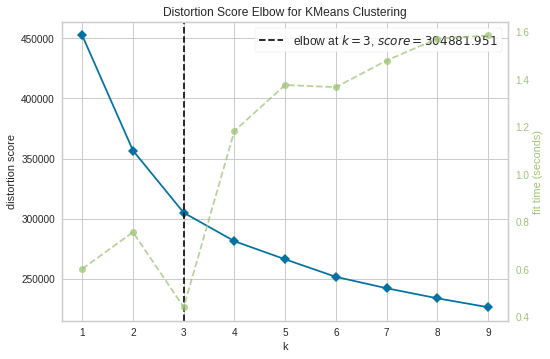

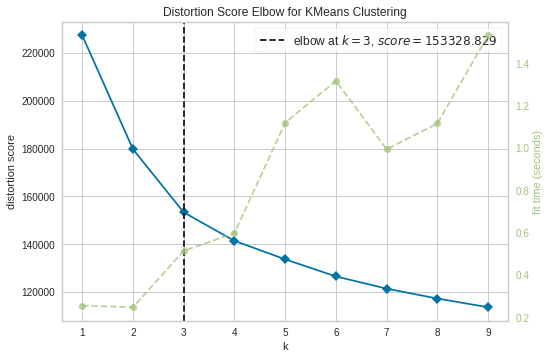

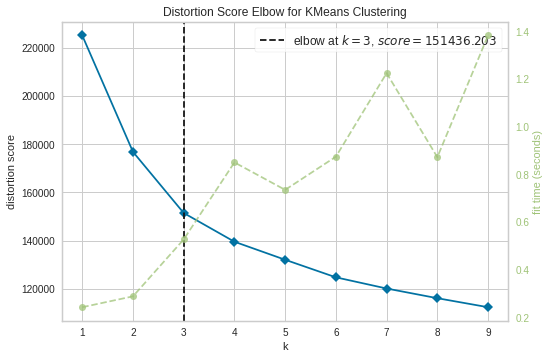

In [ ]:
get_elbow_graph(general_subset, 10)
get_elbow_graph(subset_1, 10)
get_elbow_graph(subset_2, 10)

In [ ]:
def kmeans_get_closest_to_centroid(data,n_clusters):  
  clusters=KMeans(n_clusters=n_clusters).fit(data)  
  closest, _ = pairwise_distances_argmin_min(clusters.cluster_centers_, data)
  index=[]
  print("clusters ", closest)
  for i in closest:        
    index.append(data.iloc[i])
  clusters_labels=clusters.predict(data)
  plot_clusters(data,clusters_labels)  
  return index

...............clusters main data..............
clusters  [8173 2912 7555]


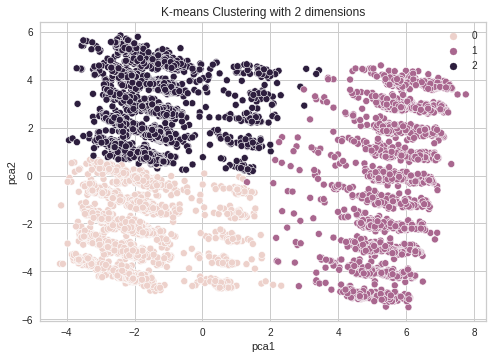

...............clusters fisrtpart data..............
clusters  [ 135 4666 2017]


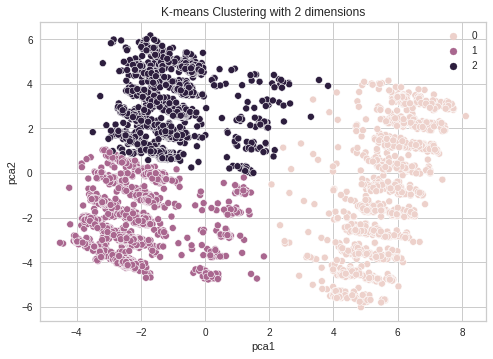

...............clusters second data..............
clusters  [4474  809 3954]


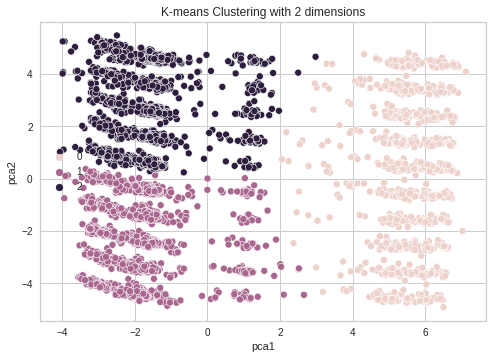

[Velocidade local             5
 Dia da Semana                3
 Características Tecnicas1    1
 Cond Aderência               8
 Zona                         2
 Tipos Vias                   1
 Estado Conservação           1
 Factores Atmosféricos        0
 Reg Circulação1              0
 Intersecção Vias             0
 Localizações                 0
 Luminosidade                 2
 Marca Via                    0
 Natureza                     1
 Sentidos                     2
 Sinais                       2
 Traçado 1                    2
 Traçado 2                    2
 Traçado 3                    1
 Via Trânsito                 1
 Periodo do Dia               2
 Tipo de Acidente             1
 Ano                          5
 Estacao do Ano               0
 Name: 6633, dtype: int64, Velocidade local             5
 Dia da Semana                3
 Características Tecnicas1    1
 Cond Aderência               8
 Zona                         2
 Tipos Vias                   1
 Estado Conser

In [ ]:
print('...............clusters main data..............')
kmeans_get_closest_to_centroid(general_subset, 3)

print('...............clusters fisrtpart data..............')
kmeans_get_closest_to_centroid(subset_1, 3)
print('...............clusters second data..............')
kmeans_get_closest_to_centroid(subset_2, 3)


## DBSCAN

In [ ]:
def choose_best_epsilon(data):
  neighbors = NearestNeighbors(n_neighbors=46)
  neighbors_fit = neighbors.fit(data)
  distances, indices = neighbors_fit.kneighbors(data)
  distances = np.sort(distances, axis=0)
  distances = distances[:,1]
  plt.plot(distances)
  plt.show()

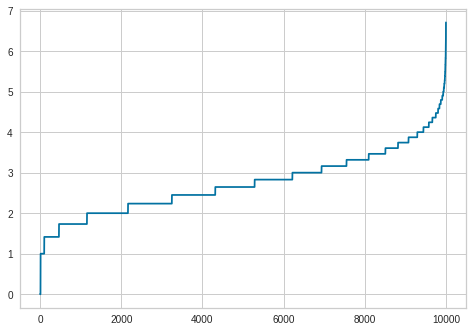

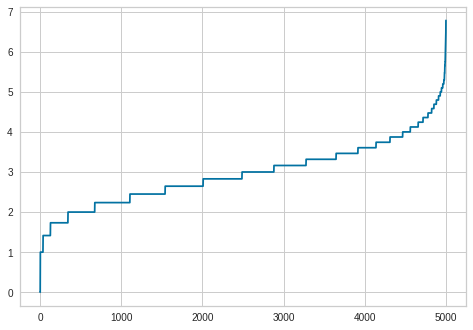

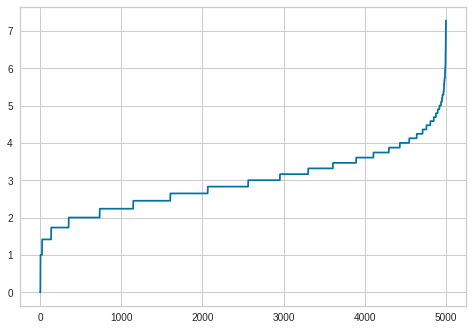

In [ ]:
choose_best_epsilon(general_subset)
choose_best_epsilon(subset_1)
choose_best_epsilon(subset_2)

In [ ]:
def dbscan_method(data, eps):
  db = DBSCAN(eps=eps, min_samples=46)
  db.fit(data)


  labels=db.labels_
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise_ = list(labels).count(-1)
  
  print("Estimated number of clusters: %d" % n_clusters_)
  print("Estimated number of noise points: %d" % n_noise_)
  plot_clusters(data,labels) 
  return labels

In [ ]:
def remove_noise_points(data, labels):
  data['cluster_labels']=labels
  data.drop(data[(data['cluster_labels'] == -1)].index, axis=0, inplace=True)
  data.drop(columns = 'cluster_labels')

Estimated number of clusters: 3
Estimated number of noise points: 6516


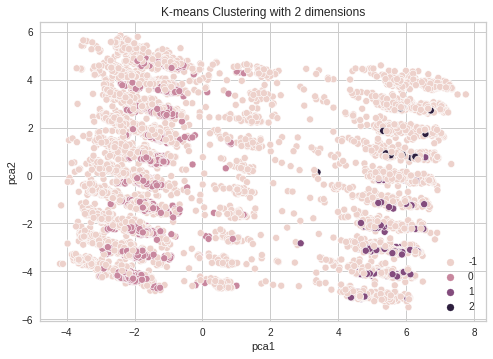

Estimated number of clusters: 2
Estimated number of noise points: 2513


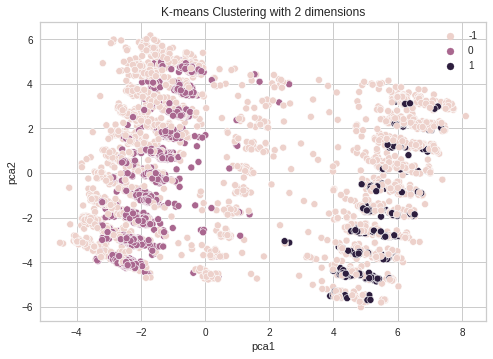

[-1 -1 -1 ... -1 -1  0]
Estimated number of clusters: 2
Estimated number of noise points: 2465


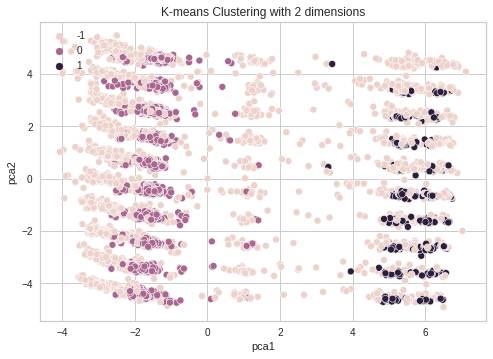

[ 0 -1  1 ...  1  0  0]


In [ ]:
labels_general_subset=dbscan_method(general_subset, 3.5)
print(dbscan_method(subset_1, 4))
print(dbscan_method(subset_2, 4))

# Ponto 7

Evaluate the possibility of predicting the seriousness of the injuries based on the remaining accident data. Notice that for supervised learning the unbalanced data is
serious problem, especially when the target has much more examples of one class
than others.
To avoid this, collect data from all files using all cases of accidents that have other types
of injuries other than "light injuries". Then sample a number of light-injuries accidents
equal to the number of non-light injuries cases. Decide whether or not to use the
remaining classes of injuries. In any case maintain only two classes of target values.
Decide whether or not to use information from passengers and pedestrians. Report
on all of these decisions. Create a reasonably balanced dataset with two classes;

In [ ]:
# remove_noise_points(accidents_df,labels_general_subset)

In [ ]:
accidents_df

,Velocidade local,Dia da Semana,Características Tecnicas1,Cond Aderência,Zona,Tipos Vias,Estado Conservação,Factores Atmosféricos,Reg Circulação1,Intersecção Vias,Localizações,Luminosidade,Marca Via,Natureza,Sentidos,Sinais,Traçado 1,Traçado 2,Traçado 3,Via Trânsito,Periodo do Dia,Tipo de Acidente,Ano,Estacao do Ano
0,50.0,Terça-Feira,Estrada sem separador,Molhado,NORTE,Arruamento,Em estado regular,Mau tempo,Dois sentidos,Fora da intersecção,Dentro das localidades,Em pleno dia,Sem marcas rodoviárias ou pouco visíveis,Despiste,NÃO DEFINIDO,Outros,Curva,Com inclinação,Sem berma ou impraticável,Direita,Manha,Ligeiro,2010,Inverno
1,50.0,Terça-Feira,Estrada sem separador,Molhado,NORTE,Arruamento,Em estado regular,Mau tempo,Dois sentidos,Fora da intersecção,Dentro das localidades,"Noite, com iluminação",Sem marcas rodoviárias ou pouco visíveis,Atropelamento,NÃO DEFINIDO,Stop,Recta,Em patamar,Sem berma ou impraticável,Direita,Noite,Ligeiro,2019,Inverno
2,50.0,Quinta-Feira,Estrada sem separador,Molhado,NORTE,Arruamento,Em bom estado,Mau tempo,Dois sentidos,Fora da intersecção,Dentro das localidades,"Noite, com iluminação",Com marcas - separadoras de sentido de trânsito,Atropelamento,NÃO DEFINIDO,Outros,Recta,Em patamar,Berma pavimentada,Direita,Noite,Ligeiro,2017,Inverno
3,60.0,Quinta-Feira,Auto-estrada,Húmido,NORTE,A - Auto-Estrada,Em estado regular,Bom tempo,Sentido único,Fora da intersecção,Fora das localidades,Aurora ou crepúsculo,Com marcas - separadoras de sentido e de vias ...,Despiste,No sentido decrescente da quilometragem,Outros,Recta,Em patamar,Berma pavimentada,Direita,Manha,Ligeiro,2017,Inverno
4,50.0,Sexta-Feira,Estrada sem separador,Seco e limpo,NORTE,Arruamento,Em bom estado,Bom tempo,Dois sentidos,Fora da intersecção,Dentro das localidades,Em pleno dia,Sem marcas rodoviárias ou pouco visíveis,Colisao,NÃO DEFINIDO,NÃO DEFINIDO,Recta,Com inclinação,NÃO DEFINIDO,Direita,Tarde,Ligeiro,2011,Inverno
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,50.0,Sexta-Feira,Estrada sem separador,Seco e limpo,NORTE,Arruamento,Em bom estado,Bom tempo,Dois sentidos,Fora da intersecção,Dentro das localidades,Em pleno dia,Sem marcas rodoviárias ou pouco visíveis,Colisao,NÃO DEFINIDO,Outros,Recta,Em patamar,Berma pavimentada,Direita,Tarde,Ligeiro,2015,Inverno
9996,50.0,Segunda-Feira,Estrada sem separador,Seco e limpo,NORTE,Arruamento,Em estado regular,Bom tempo,Dois sentidos,Fora da intersecção,Dentro das localidades,Em pleno dia,Com marcas - separadoras de sentido de trânsito,Despiste,NÃO DEFINIDO,NÃO DEFINIDO,Recta,Com inclinação,Berma pavimentada,Direita,Tarde,Ligeiro,2016,Inverno
9997,50.0,Terça-Feira,Estrada sem separador,Seco e limpo,AREA METROPOLITANA DE LISBOA,EN - Estrada Nacional,Em bom estado,Bom tempo,Dois sentidos,Fora da intersecção,Dentro das localidades,"Noite, sem iluminação",Sem marcas rodoviárias ou pouco visíveis,Despiste,NÃO DEFINIDO,NÃO DEFINIDO,Recta,Com inclinação,Berma pavimentada,Direita,Noite,Ligeiro,2015,Inverno
9998,50.0,Segunda-Feira,Estrada sem separador,Molhado,AREA METROPOLITANA DE LISBOA,Arruamento,Em bom estado,Mau tempo,Dois sentidos,Fora da intersecção,Dentro das localidades,Em pleno dia,Com marcas - separadoras de sentido de trânsito,Despiste,NÃO DEFINIDO,NÃO DEFINIDO,Recta,Em patamar,Sem berma ou impraticável,Direita,Manha,Ligeiro,2015,Inverno


In [ ]:
accidents_df.groupby(['Tipo de Acidente']).size()

Tipo de Acidente
Grave           524
Ligeiro        9296
Muito grave     180
dtype: int64

In [ ]:
#FICAR APENA COM ACIDENTES LIGEIROS E OS OUTROS (GRAVE E MUITO GRAVE ) JUNTOS 
#NOME DA COLUNA Tipo de Acidente ='Acidente Ligeiro' E VALORES COM TRUE OU FALSE
injuries_df= pd.DataFrame(columns = accidents_df.columns)

muito_grave_injures=accidents_df[(accidents_df['Tipo de Acidente']=='Muito grave') | (accidents_df['Tipo de Acidente']=='Grave')]
injuries_df=pd.concat([injuries_df,muito_grave_injures], ignore_index = True)
ligeiro_injures=accidents_df[accidents_df['Tipo de Acidente']=='Ligeiro'].sample(len(injuries_df))
injuries_df=pd.concat([injuries_df,ligeiro_injures], ignore_index = True)

injuries_df['Tipo de Acidente'] = injuries_df['Tipo de Acidente'].str.replace('Muito grave', 'Grave')

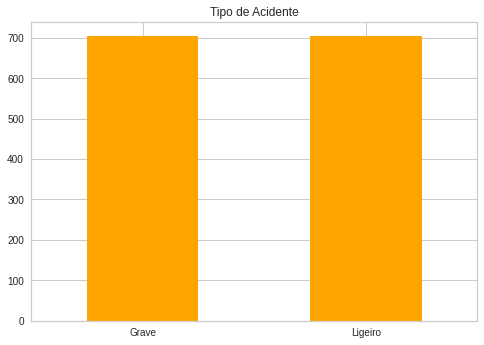

In [ ]:
injuries_df['Tipo de Acidente'].value_counts().plot(kind = 'bar',rot = 0,color='orange',title="Tipo de Acidente")

# Ponto 8

Test three training/validation partitions in each supervised learning trial: k-fold crossvalidation and two simple cross-validations with different datasets: random 30% and
last 30% splits;

In [ ]:
#CORREALACO COM A VARIAVEL Tipo de Acidente VER QUAIS AS COLUNAS A USAR para fazer previsoes 


m=cramer_matrix(['Tipo de Acidente'], injuries_df.columns, injuries_df)
dd = pd.DataFrame(m, index = ['Tipo de Acidente'], columns = injuries_df.columns)
pd.set_option('display.max_columns', None)
dd

,Velocidade local,Dia da Semana,Características Tecnicas1,Cond Aderência,Zona,Tipos Vias,Estado Conservação,Factores Atmosféricos,Reg Circulação1,Intersecção Vias,Localizações,Luminosidade,Marca Via,Natureza,Sentidos,Sinais,Traçado 1,Traçado 2,Traçado 3,Via Trânsito,Periodo do Dia,Tipo de Acidente,Ano,Estacao do Ano
Tipo de Acidente,0.21,0.11,0.03,0.14,0.17,0.2,0.06,0.14,0.09,0.12,0.15,0.15,0.07,0.11,0.03,0.1,0.06,0.08,0.1,0.03,0.11,1.0,0.08,0.05


In [ ]:
injuries_df = injuries_df.drop(columns = ['Características Tecnicas1','Cond Aderência','Estado Conservação','Factores Atmosféricos','Sentidos','Traçado 1','Traçado 2','Via Trânsito','Estacao do Ano'])

In [ ]:
numeric_injuries_df= injuries_df.copy()
numeric_injuries_df=categorical_to_numeric(numeric_injuries_df)

numeric_injuries_ordered_by_year_df = injuries_df.copy()
numeric_injuries_ordered_by_year_df.sort_values(by='Ano', ascending=True, inplace=True)
numeric_injuries_ordered_by_year_df=categorical_to_numeric(numeric_injuries_ordered_by_year_df)

## k-fold crossvalidation

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=3)
kf.get_n_splits(accidents_df)

print(kf)

for i, (train_index_kFold, test_index_kFold) in enumerate(kf.split(accidents_df)):
    print(f"Fold {i}:")
    print(f"  Train: index={len(train_index_kFold)}")
    print(f"  Test:  index={len(test_index_kFold)}")

KFold(n_splits=3, random_state=None, shuffle=False)
Fold 0:
  Train: index=6666
  Test:  index=3334
Fold 1:
  Train: index=6667
  Test:  index=3333
Fold 2:
  Train: index=6667
  Test:  index=3333


## Simple Cross Validation


1º cross validation- 70% dos dados do dataset para treino e 30% dos dados para teste , este ultimos devem ser random

2º cross validation - 70% dos primeiros dados do dataset para treino e 30% dos ultimos dados para teste

In [ ]:
X = numeric_injuries_df[numeric_injuries_df.columns.difference(['Tipo de Acidente'])]
y = numeric_injuries_df.loc[:, ['Tipo de Acidente']]
y = y.values.ravel()

In [ ]:
def generate_train_and_test(seed):
  return train_test_split(X, y, test_size=0.3, random_state=seed)

## last 30 -cross Validation

In [ ]:
X_last = numeric_injuries_ordered_by_year_df[numeric_injuries_ordered_by_year_df.columns.difference(['Tipo de Acidente'])]
y_last = numeric_injuries_ordered_by_year_df.loc[:, ['Tipo de Acidente']]
y_last = y_last.values.ravel()

In [ ]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_last, y_last, shuffle=False, test_size=0.3)

# Ponto 9

Use at least three supervised methods:

* Decision Tree
* Multi Layer Perceptron (NeuralNetworks)
* XGBoost.

The evaluation of the generated models should include different metrics and means to better understand the errors of the supervised learning approaches, namely:

* confusion matrices
* F-scores.

For any method that contains a random decision / initialization the result must be an average of 30 trials.

In [ ]:
def thirty_trials_average(classifier, validation_type_function= None):
  accuracy = 0
  f1_scores = 0
  f1_score_max=0
  confusion_matrix = np.empty((2,2))

  for i in range(30):
    results = validation_type_function(classifier,i)
    accuracy += results[0]
    f1_scores += results[1]
    if(results[1] >f1_score_max ):
      f1_score_max=results[1]
      confusion_matrix = results[2]
  
  accuracy = accuracy/30
  f1_scores = f1_scores/30

  print("Average accuracy: ", accuracy)
  print("Average f1_score: ", f1_scores)
  print("Best Confusion matrix: ", confusion_matrix)

## Decision Tree



https://towardsdatascience.com/understanding-decision-tree-classification-with-scikit-learn-2ddf272731bd

https://www.baeldung.com/cs/cross-validation-decision-trees

Since these are categorical variables if we want to apply decision tree classifier and fit to data, first we need to create dummy variables.

### K-fold

In [ ]:
def dtree_classifier_kfold(tree, seed):
  
  kf = KFold(n_splits=3)
  score = cross_val_score(tree, X, y, cv= kf)
  y_pred = cross_val_predict(tree, X, y, cv= kf)
 
  matrix = sk_confusion_matrix(y, y_pred)
  accuracy= accuracy_score(y, y_pred)
  
  return accuracy, score.max(), matrix

In [ ]:
thirty_trials_average(classifier = tree.DecisionTreeClassifier(random_state= 42), validation_type_function = dtree_classifier_kfold)

Average accuracy:  0.4183238636363634
Average f1_score:  0.5522388059701488
Best Confusion matrix:  [[297 407]
 [412 292]]


### Random simple cross-validation

In [ ]:
def dtree_simple_classifier(X_train, y_train, X_test, y_test, dtree):

  dtree.fit(X_train, y_train)
  y_pred = dtree.predict(X_test)  
  accuracy=accuracy_score(y_test, y_pred)
  score = sk_f1_score(y_test, y_pred, average='weighted')
  matrix = sk_confusion_matrix(y_test, y_pred)
  return accuracy, score, matrix

In [ ]:
def dtree_classifier(dtree, seed):
  X_train, X_test, y_train, y_test = generate_train_and_test(seed) 
  accuracy, score, matrix = dtree_simple_classifier(X_train, y_train, X_test, y_test,dtree)
  return accuracy, score, matrix

In [ ]:
thirty_trials_average(classifier = tree.DecisionTreeClassifier(random_state= 42), validation_type_function = dtree_classifier)

Average accuracy:  0.5442080378250591
Average f1_score:  0.5440232157495214
Best Confusion matrix:  [[117  75]
 [101 130]]


### Last30 simple cross-validation

In [ ]:
accuracy, f1_score, confusion_matrix = dtree_simple_classifier(X_train_2, y_train_2, X_test_2, y_test_2, dtree = tree.DecisionTreeClassifier())
print("Average accuracy: ", accuracy)
print("Average f1_score: ", f1_score) 
print("Confusion matrix: ", confusion_matrix)

Average accuracy:  0.5602836879432624
Average f1_score:  0.5312235390879918
Confusion matrix:  [[ 67 147]
 [ 39 170]]


## Multi Layer Perceptron (NeuralNetworks)

### K-fold

It's worth noting that increasing the number of iterations too much could lead to overfitting and also the model may take a long time to run.

It's also worth noting that the max_iter parameter is set to a large value, this is a parameter that controls the maximum number of iterations for the solver to converge, you can try different values to see which one is the best for your problem.

In [ ]:

def neural_networks_kfold_classifier(nn, seed):
  kf = KFold(n_splits=3)
  score = cross_val_score(nn, X, y, cv= kf)
  y_pred = cross_val_predict(nn, X, y, cv= kf)
 
 
  matrix = sk_confusion_matrix(y, y_pred)
  accuracy= accuracy_score(y, y_pred)
  return accuracy, score.max(), matrix

In [ ]:
nn = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1, max_iter= 600)
thirty_trials_average(classifier = nn, validation_type_function = neural_networks_kfold_classifier)

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

Average accuracy:  0.2130681818181817
Average f1_score:  0.5245202558635392
Best Confusion matrix:  [[269 435]
 [673  31]]


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### Random simple cross-validation

In [ ]:
nn = MLPClassifier(solver='lbfgs', alpha=1e-5,
                      hidden_layer_sizes=(5, 2), random_state=1, max_iter= 600)

In [ ]:
def neural_networks_simple_classifier(X_train, y_train, X_test, y_test, nn):
 
  nn.fit(X_train, y_train)
  y_pred = nn.predict(X_test)
  accuracy=accuracy_score(y_test, y_pred)
  
  score = sk_f1_score(y_test, y_pred, average='weighted')
  matrix = sk_confusion_matrix(y_test, y_pred)
  return accuracy, score, matrix

In [ ]:
def neural_networks_classifier(nn, seed):
  X_train, X_test, y_train, y_test = generate_train_and_test(seed) 
  accuracy, score, matrix = neural_networks_simple_classifier(X_train, y_train, X_test, y_test, nn)
  return accuracy, score, matrix

In [ ]:
thirty_trials_average(classifier = nn, validation_type_function = neural_networks_classifier)

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

Average accuracy:  0.5815602836879434
Average f1_score:  0.5616633852610659
Best Confusion matrix:  [[122  78]
 [ 69 154]]


### Last 30 simple cross-validation

In [ ]:
accuracy, f1_score, confusion_matrix = neural_networks_simple_classifier(X_train_2, y_train_2, X_test_2, y_test_2, nn)
print("Average accuracy: ", accuracy)
print("Average f1_score: ", f1_score)
print("Confusion matrix: ", confusion_matrix)

Average accuracy:  0.5839243498817966
Average f1_score:  0.557523835976781
Confusion matrix:  [[ 73 141]
 [ 35 174]]


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


## XGBoots

### K-fold

In [ ]:
def xg_boost_classifier_kfold(xgb, seed):
  
  kf = KFold(n_splits=3)
  score = cross_val_score(xgb, X, y, cv= kf)
  y_pred = cross_val_predict(xgb, X, y, cv= kf)
 
  matrix = sk_confusion_matrix( y, y_pred)
  accuracy= accuracy_score(y, y_pred)
  
  return accuracy, score.max(), matrix

In [ ]:
thirty_trials_average(classifier = XGBClassifier(), validation_type_function = xg_boost_classifier_kfold)

Average accuracy:  0.26917613636363646
Average f1_score:  0.6034115138592747
Best Confusion matrix:  [[214 490]
 [539 165]]


### Random simple cross-validation

In [ ]:
def xg_boost_simple_classifier(X_train, y_train, X_test, y_test, xgb):
  xgb.fit(X_train, y_train)
  # Make predictions on the test data
  y_pred = xgb.predict(X_test)
  accuracy=accuracy_score(y_test, y_pred)
  score = sk_f1_score(y_test, y_pred, average='weighted')
  matrix = sk_confusion_matrix(y_test, y_pred)
  return accuracy, score, matrix

In [ ]:
def xg_boost_classifier(xgb, seed):
  X_train, X_test, y_train, y_test = generate_train_and_test(seed) 
  accuracy, score, matrix = xg_boost_simple_classifier(X_train, y_train, X_test, y_test,xgb)
  return accuracy, score, matrix

In [ ]:
thirty_trials_average(classifier = XGBClassifier(), validation_type_function = xg_boost_classifier)

Average accuracy:  0.6070133963750985
Average f1_score:  0.6062211404074127
Best Confusion matrix:  [[127  81]
 [ 68 147]]


### Last 30 simple cross-validation

In [ ]:
accuracy, f1_score, confusion_matrix=xg_boost_simple_classifier(X_train_2, y_train_2, X_test_2, y_test_2,xgb=XGBClassifier())
print("Average accuracy: ", accuracy)
print("Average f1_score: ", f1_score)
print("Confusion matrix: ", confusion_matrix)

Average accuracy:  0.4940898345153664
Average f1_score:  0.32678726396744173
Confusion matrix:  [[  0 214]
 [  0 209]]
